## Run Infomap on Selected NT(s)

In [20]:
import pandas as pd
import numpy as np
import os
import subprocess
from ipywidgets import Checkbox, VBox, Button, Output
from IPython.display import display
from tqdm.notebook import tqdm

# Load connection data
df = pd.read_csv("connections_princeton.csv")
nt_types = sorted(df['nt_type'].dropna().unique())

top_n_modules = 15  # Change this number to control how many top communities to show

# Create checkboxes
checkboxes = [Checkbox(value=False, description=nt) for nt in nt_types]
checkbox_box = VBox(checkboxes)
last_combo_name = None  # global placeholder for file names

# Button to generate Pajek files + run Infomap
run_button = Button(description="Run Infomap", button_style='success')
output = Output()

def make_pajek_file(df, nt_types, outname):
    nt_df = df[df['nt_type'].isin(nt_types)]
    edges = (
        nt_df.groupby(['pre_root_id', 'post_root_id'])['syn_count']
        .sum()
        .reset_index()
        .rename(columns={'pre_root_id': 'source', 'post_root_id': 'target', 'syn_count': 'weight'})
    )

    all_nodes = pd.Index(edges['source'].tolist() + edges['target'].tolist()).unique()
    node_to_id = {node: idx + 1 for idx, node in enumerate(all_nodes)}

    with open(outname, "w") as f:
        f.write(f"*Vertices {len(all_nodes)}\n")
        for node in all_nodes:
            f.write(f'{node_to_id[node]} "{node}"\n')
        f.write("*Edges\n")
        for _, row in edges.iterrows():
            f.write(f"{node_to_id[row['source']]} {node_to_id[row['target']]} {row['weight']}\n")

def run_infomap(input_file, output_dir):
    # Make sure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    cmd = [
        "infomap", input_file, output_dir,
        "--two-level", "--num-trials", "50"
    ]
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    
    if result.returncode != 0:
        raise RuntimeError(f"Infomap error:\n{result.stderr}")
    return result.stdout

# Button callback


def on_button_clicked(b):
    global last_combo_name, last_selected_nts  # <-- needed to retain the value later

    output.clear_output()
    selected_nts = [cb.description for cb in checkboxes if cb.value]

    if not selected_nts:
        with output:
            print("Please select at least one neurotransmitter.")
        return

    with output:
        print(f"Merging {len(selected_nts)} neurotransmitters into one graph...")

    try:
        combo_name = "_".join(sorted(nt.lower() for nt in selected_nts))
        outdir = f"output_{combo_name}"
        pajek_file = f"{outdir}/{combo_name}_graph.net"  # Save .net in output folder

        os.makedirs(outdir, exist_ok=True)  # Ensure folder exists
        make_pajek_file(df, nt_types=selected_nts, outname=pajek_file)
        result = run_infomap(pajek_file, outdir)

        last_combo_name = combo_name
        last_selected_nts = selected_nts

        with output:
            print(f"Infomap complete for: {', '.join(selected_nts)} → {outdir}")

    except Exception as e:
        with output:
            print(f"Error:\n{e}")

run_button.on_click(on_button_clicked)

# Display GUI
display(VBox([checkbox_box, run_button, output]))

## Plot Communities in 3D Space

In [21]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ====== STEP 0: Check that neurotransmitters were selected ======
try:
    selected_nts = last_selected_nts
except NameError:
    raise ValueError("Please run the Infomap step first by clicking the button.")

# ====== STEP 1: Define file paths ======
nt_clean = "_".join(sorted(nt.lower() for nt in selected_nts))
tree_file = f"output_{nt_clean}/{nt_clean}_graph.tree"
coords_file = "coordinates.csv"
pajek_file = f"output_{nt_clean}/{nt_clean}_graph.net"

# ====== STEP 2: Rebuild node ID mapping from Pajek file ======
id_to_node = {}
with open(pajek_file, "r") as f:
    for line in f:
        if line.startswith("*Vertices"):
            continue
        if line.startswith("*Edges"):
            break
        parts = line.strip().split()
        if len(parts) >= 2:
            id_num = int(parts[0])
            root_id = parts[1].strip('"')
            id_to_node[id_num] = root_id

# ====== STEP 3: Load Infomap tree file ======
tree_data = []
with open(tree_file, "r") as f:
    for line in f:
        if line.startswith("#"):
            continue
        parts = line.strip().split()
        module_path = parts[0]
        node_index = int(parts[-1])
        root_id = str(id_to_node.get(node_index, "UNKNOWN"))
        tree_data.append((root_id, module_path))

modules_df = pd.DataFrame(tree_data, columns=["neuron_id", "module_path"])
modules_df["top_module"] = modules_df["module_path"].str.split(":").str[0].astype(int)

# ====== STEP 4: Merge with neuron coordinates ======
positions_df = pd.read_csv(coords_file)
positions_df["neuron_id"] = positions_df["root_id"].astype(str)
merged = pd.merge(modules_df, positions_df, on="neuron_id")

# ====== STEP 5: Limit to Top n Modules ======
top_modules = merged["top_module"].value_counts().head(top_n_modules).index.tolist()
top_merged = merged[merged["top_module"].isin(top_modules)].copy()

# Convert "[x y z]" string to numeric columns
top_merged[["x", "y", "z"]] = top_merged["position"].apply(
    lambda s: pd.Series(np.fromstring(s.strip("[]"), sep=" "))
)

# ====== STEP 6: Interactive 3D Plot with Plotly ======
fig = go.Figure()
for module in top_merged["top_module"].unique():
    cluster = top_merged[top_merged["top_module"] == module]
    fig.add_trace(go.Scatter3d(
        x=cluster["x"],
        y=cluster["y"],
        z=cluster["z"],
        mode='markers',
        marker=dict(size=2, opacity=0.8),
        name=f"Module {module}"
    ))

fig.update_layout(
    title=f"Top {top_n_modules} Infomap Communities for {last_combo_name.upper()}",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    legend_title="Infomap Module",
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

## Plot Similarity Matrix

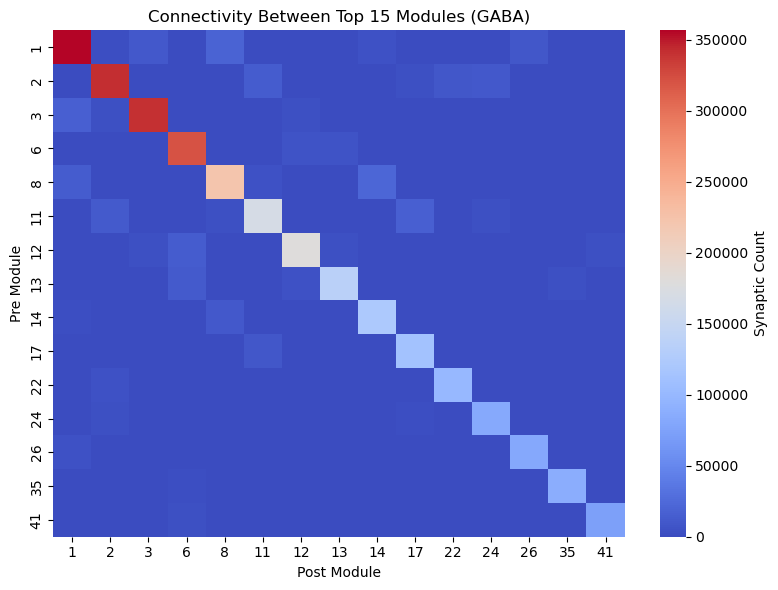

In [15]:
import pandas as pd
import numpy as np

# ====== STEP 0: Load necessary files ======
# Uses the same `last_combo_name` and `last_selected_nts` from previous steps
nt_clean = "_".join(sorted(nt.lower() for nt in last_selected_nts))
tree_file = f"output_{nt_clean}/{nt_clean}_graph.tree"
pajek_file = f"{nt_clean}_graph.net"
coords_file = "coordinates.csv"
df_edges = pd.read_csv("connections_princeton.csv")

# Filter to selected NTs only
df_edges = df_edges[df_edges['nt_type'].isin(last_selected_nts)].copy()
df_edges["pre_root_id"] = df_edges["pre_root_id"].astype(str)
df_edges["post_root_id"] = df_edges["post_root_id"].astype(str)

# ====== STEP 1: Load Tree to get module assignments ======
id_to_node = {}
with open(pajek_file, "r") as f:
    for line in f:
        if line.startswith("*Vertices"):
            continue
        if line.startswith("*Edges"):
            break
        parts = line.strip().split()
        if len(parts) >= 2:
            id_num = int(parts[0])
            root_id = parts[1].strip('"')
            id_to_node[id_num] = root_id

tree_data = []
with open(tree_file, "r") as f:
    for line in f:
        if line.startswith("#"):
            continue
        parts = line.strip().split()
        module_path = parts[0]
        node_index = int(parts[-1])
        root_id = str(id_to_node.get(node_index, "UNKNOWN"))
        tree_data.append((root_id, module_path))

modules_df = pd.DataFrame(tree_data, columns=["neuron_id", "module_path"])
modules_df["top_module"] = modules_df["module_path"].str.split(":").str[0].astype(int)

# Keep only top N modules
top_modules = modules_df["top_module"].value_counts().head(top_n_modules).index.tolist()
modules_df = modules_df[modules_df["top_module"].isin(top_modules)].copy()

# Create lookup table for neuron → module
neuron_to_module = dict(zip(modules_df["neuron_id"], modules_df["top_module"]))

# ====== STEP 2: Annotate original connections with module assignments ======
df_edges["pre_module"] = df_edges["pre_root_id"].map(neuron_to_module)
df_edges["post_module"] = df_edges["post_root_id"].map(neuron_to_module)

# Drop edges where either side isn’t in a top module
df_edges = df_edges.dropna(subset=["pre_module", "post_module"])

# Convert to int
df_edges["pre_module"] = df_edges["pre_module"].astype(int)
df_edges["post_module"] = df_edges["post_module"].astype(int)

# ====== STEP 3: Create connectivity matrix ======
connect_mat = df_edges.groupby(["pre_module", "post_module"])["syn_count"].sum().unstack(fill_value=0)

# Optional: sort rows/columns by module number
connect_mat = connect_mat.reindex(index=sorted(connect_mat.index), columns=sorted(connect_mat.columns))

# ====== STEP 4: Display and/or save ======
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(connect_mat, cmap="coolwarm", annot=False, cbar_kws={"label": "Synaptic Count"})
plt.title(f"Connectivity Between Top {top_n_modules} Modules ({last_combo_name.upper()})")
plt.xlabel("Post Module")
plt.ylabel("Pre Module")
plt.tight_layout()
plt.show()

# Save to CSV
connect_mat.to_csv(f"{nt_clean}_top{top_n_modules}_module_connectivity.csv")

## Run Louvain Community Detection

In [25]:
import pandas as pd
import networkx as nx
import community  # pip install python-louvain
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# ====== STEP 0: Load edge list from Pajek file ======
pajek_file = f"{last_combo_name}_graph.net"

G = nx.read_pajek(pajek_file)
G = nx.Graph(G)  # Louvain requires undirected

# ====== STEP 1: Run Louvain community detection ======
partition = community.best_partition(G, weight='weight')  # dict: node -> community ID

# Convert to DataFrame
louvain_df = pd.DataFrame(list(partition.items()), columns=["neuron_id", "louvain_module"])
louvain_df["neuron_id"] = louvain_df["neuron_id"].astype(str)

# ====== STEP 2: Merge with coordinates ======
coords_df = pd.read_csv("coordinates.csv")
coords_df["neuron_id"] = coords_df["root_id"].astype(str)
merged = pd.merge(louvain_df, coords_df, on="neuron_id", how="inner")

# Convert position to x, y, z columns
merged[["x", "y", "z"]] = merged["position"].apply(
    lambda s: pd.Series(np.fromstring(s.strip("[]"), sep=" "))
)

# ====== STEP 3: Plot top 15 Louvain communities ======
top_louvain_modules = merged["louvain_module"].value_counts().head(15).index.tolist()
top_merged = merged[merged["louvain_module"].isin(top_louvain_modules)]

fig = go.Figure()
for module_id in sorted(top_louvain_modules):
    cluster = top_merged[top_merged["louvain_module"] == module_id]
    fig.add_trace(go.Scatter3d(
        x=cluster["x"],
        y=cluster["y"],
        z=cluster["z"],
        mode='markers',
        marker=dict(size=2, opacity=0.8),
        name=f"Louvain {module_id}"
    ))

fig.update_layout(
    title=f"Top 15 Louvain Communities for {last_combo_name.upper()}",
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
    legend_title="Louvain Module",
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()